# Camera calibration

In [2]:
##Camera Calibration
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


save_dir= r'output_images/chess/'

#Prepare object points (0,0,0),(1,0,0),(2,0,0) ....,(8,4,0)
objp = np.zeros((9*6,3), np.float32)
#print(objp)
objp[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2)
#print(objp)

objpoints=[] #3d points in real world
imgpoints=[] #2d points in image

#Images to calibrate from
img_files = glob.glob('camera_cal/*.jpg')
#print(img_files)
"""
[X] Find chessboard corners
[X] Add image points, object points
[X] Display corners
[X] Camera calibration
"""

for file in img_files:
    #Get file sufix
    sufix=file[22:]
    #print("Opening file: "+sufix)
    img=cv2.imread(file)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #If corners exist
    if ret == True:
        print(sufix+" Corners Found!")
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        file_name= save_dir + 'chess_corners' + sufix
        #print(file_name)
        print("Saving Image...")
        cv2.imwrite(file_name, img)
    else:
        print("No corners found on {}!".format(sufix))
    
img_size=(img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

camCal_pickle={"mtx": mtx,
              "dist": dist,
              "rvecs": rvecs,
              "tvecs": tvecs}
pickle.dump(camCal_pickle, open ('CamCal/camCal_pickle.p', "wb") )
print("Pickle Saved")

No corners found on 1.jpg!
10.jpg Corners Found!
Saving Image...
11.jpg Corners Found!
Saving Image...
12.jpg Corners Found!
Saving Image...
13.jpg Corners Found!
Saving Image...
14.jpg Corners Found!
Saving Image...
15.jpg Corners Found!
Saving Image...
16.jpg Corners Found!
Saving Image...
17.jpg Corners Found!
Saving Image...
18.jpg Corners Found!
Saving Image...
19.jpg Corners Found!
Saving Image...
2.jpg Corners Found!
Saving Image...
20.jpg Corners Found!
Saving Image...
3.jpg Corners Found!
Saving Image...
No corners found on 4.jpg!
No corners found on 5.jpg!
6.jpg Corners Found!
Saving Image...
7.jpg Corners Found!
Saving Image...
8.jpg Corners Found!
Saving Image...
9.jpg Corners Found!
Saving Image...
Pickle Saved


# Distortion Correction
Uses previously calibrated camera and params

In [3]:
## Distortion correction
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

Cam_Calib=pickle.load( open("CamCal/camCal_pickle.p", "rb"))

cam_dist=Cam_Calib["dist"]
cam_mtx=Cam_Calib["mtx"]
img_files = glob.glob('test_images/*.jpg')
save_dir= r'output_images/undist/'

for file in img_files:
    img= cv2.imread(file)
    sufix=file[12:]
    dst=cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    cv2.imwrite(save_dir+sufix[:-4]+"_undist.jpg", dst)
    
    


# Image preprocessing (Gradient threshold)

In [1]:
#Gradient Threshold
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

#Sobel kernels from http://homepages.inf.ed.ac.uk/rbf/HIPR2/linedet.htm

up_kernel = [[-1.,-1.,2.],
         [-1.,2.,-1.],
         [2.,-1.,-1.]]
up_kernel=np.asarray(up_kernel)/12.0


down_kernel = [[2.,-1.,-1.],
         [-1.,2.,-1.],
         [-1.,-1.,2.]]
down_kernel=np.asarray(down_kernel)/12.0


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Orientation threshold, asumes img is gray image"""
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x=np.abs(sobel_x)
    abs_y=np.abs(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    orient_sobel=np.arctan2(abs_y,abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(orient_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(orient_sobel>thresh[0])&(orient_sobel<thresh[1])]=1 # Remove this line
    return binary_output

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
    """Axis sobel, asumes img is gray image, returns binary image"""
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    elif orient=='+':
        sobel = cv2.filter2D(gray,-1,up_kernel)
    elif orient=='-':
        sobel = cv2.filter2D(gray,-1,down_kernel)
    else:
        raise "Not valid orientation!"
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output=np.zeros_like(scaled_sobel)
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel>thresh_min) & (scaled_sobel<thresh_max)] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    """Magnitude, asumes img is gray image"""
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel=np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_sobel=np.uint8(abs_sobel*255/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scale_sobel)
    binary_output[(scale_sobel>mag_thresh[0])&(scale_sobel<mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

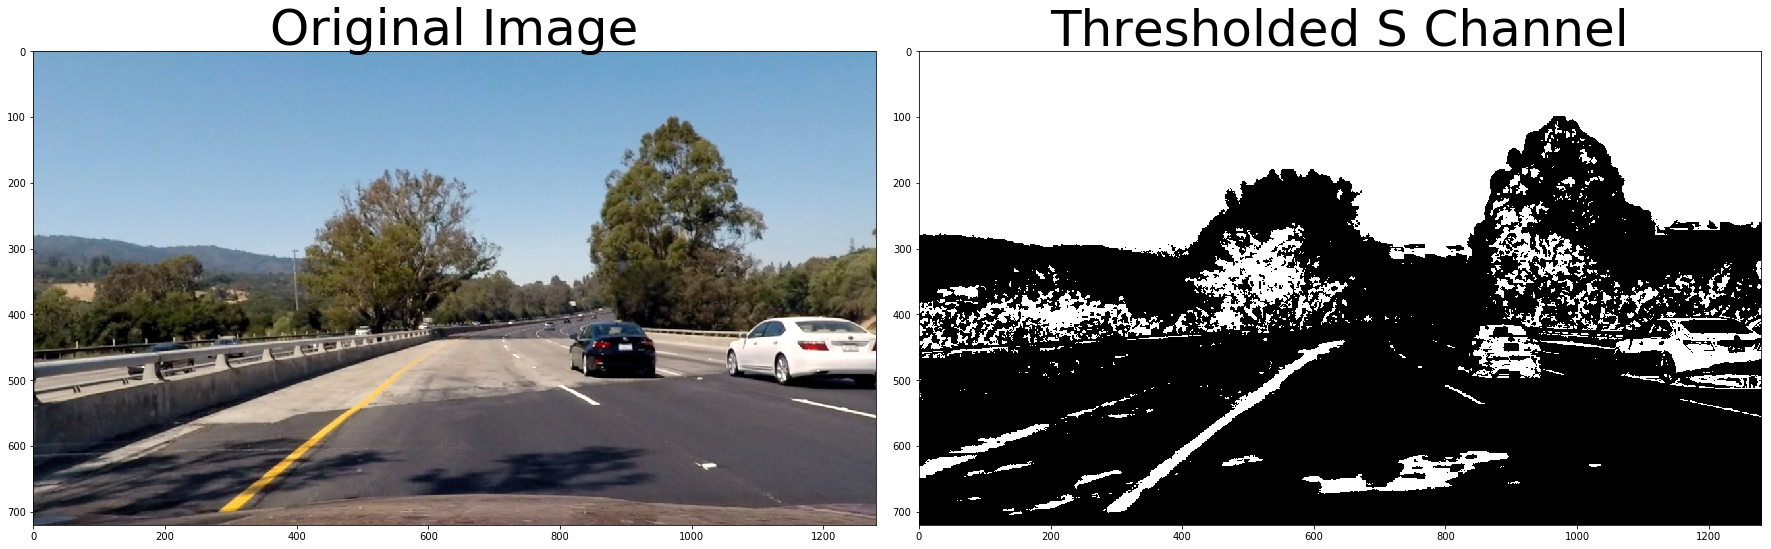

In [2]:
def multiple_threshold(kernel, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_or, max_or):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    gradx=abs_sobel_thresh(image, orient='x', thresh_min=min_gradx, thresh_max=max_gradx, sobel_kernel=kernel)
    grady=abs_sobel_thresh(image, orient='y', thresh_min=min_grady, thresh_max=max_grady, sobel_kernel=kernel)
    binary_dir=np.zeros_like(gradx)
    binary_dir[(gradx==1)&(grady==1)]=1
    # 2)Apply sobel Magnitude
    bin_mag=mag_thresh(image, sobel_kernel=kernel, mag_thresh=(min_mag,max_mag))

    # 3)Apply sobel orientation
    # 4)Mix all above
    
    
    binary_output=np.zeros_like(gradx)
    binary_output[(binary_dir==1)|bin_mag==1]=1
    #binary_output[(orient_sobel>min_or)&(orient_sobel<max_or)]=1 # Remove this line
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(binary_output, cmap='gray')
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
color_image=mpimg.imread("output_images/undist/test4_undist.jpg")
image=cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
image=cv2.blur(image,(7,7))

%matplotlib inline

HLS_img=cv2.cvtColor(color_image, cv2.COLOR_RGB2HLS)
S_channel= HLS_img[:,:,2]
def test_hls_tresh(low_limit=0, high_limit=255):
    s_binary=np.zeros_like(S_channel)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(color_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(s_binary, cmap='gray')
    #ax2.imshow(S_channel, cmap='gray')
    ax2.set_title('Thresholded S Channel', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

from ipywidgets import *
interact(test_hls_tresh, low_limit=(0,255), high_limit=(0,255))

# Experiment Below!

<function __main__.test_multiple_threshold>

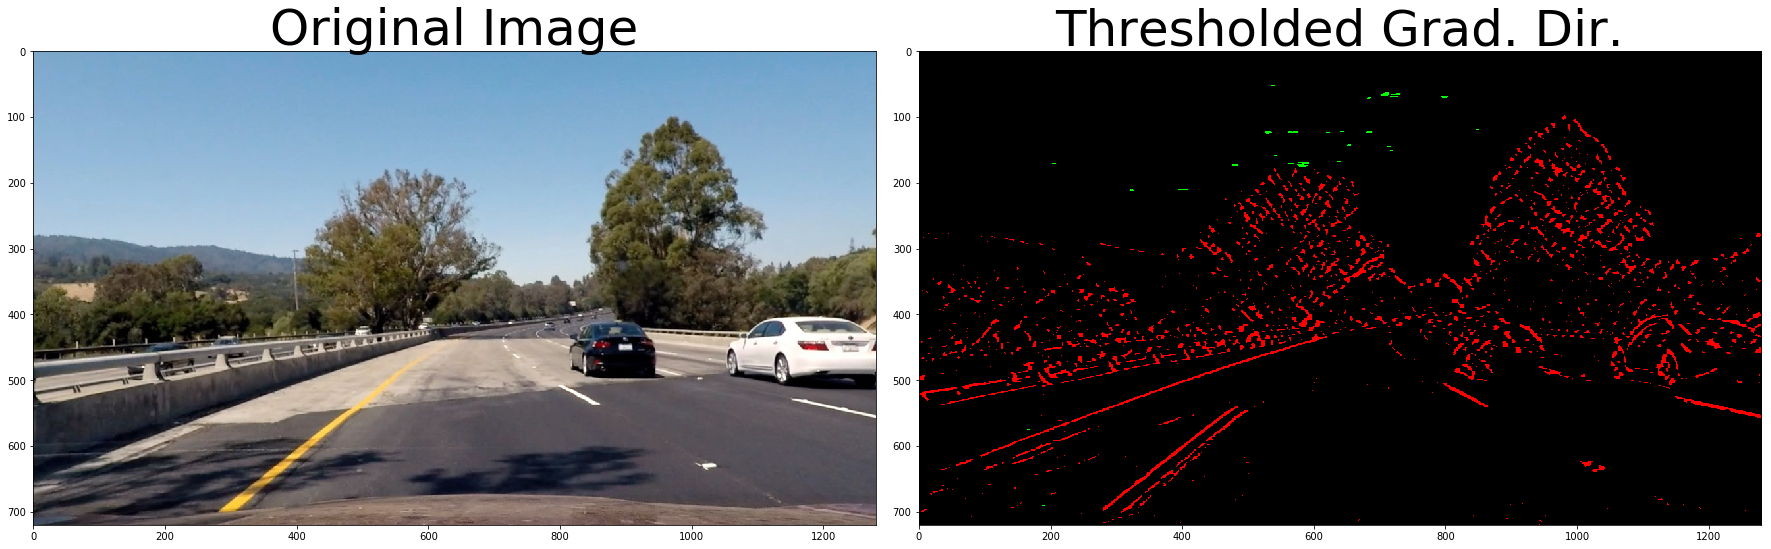

In [3]:
from ipywidgets import *

def hls_tresh(low_limit=0, high_limit=255):
    s_binary=np.zeros_like(S_channel)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    return s_binary

def test_multiple_threshold(kernel, min_gradx, max_gradx, min_dt, max_dt, min_mag, max_mag, min_or, max_or, s_low, s_high ):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    gradx=abs_sobel_thresh(image, orient='x', thresh_min=min_gradx, thresh_max=max_gradx, sobel_kernel=kernel)
    #Less significant on Y axis , lots of noise
    #grady=abs_sobel_thresh(image, orient='y', thresh_min=min_grady, thresh_max=max_grady, sobel_kernel=kernel)
    binary_dir=np.zeros_like(gradx)
    #binary_dir[(gradx==1)|(grady==1)]=1
    
    #Diagonal Sobels!
    pos=abs_sobel_thresh(image, orient='+', thresh_min=min_dt, thresh_max=max_dt)
    neg=abs_sobel_thresh(image, orient='-', thresh_min=min_mag, thresh_max=max_mag)
    bin_diag=np.zeros_like(pos)
    bin_diag[(pos==1)|(neg==1)]=1
    bin_diag=cv2.morphologyEx(bin_diag, cv2.MORPH_CLOSE, np.ones((3,5),np.uint8))
    
    # 2)Apply sobel Magnitude
    #Even smaller magnitudes cause noise
    #bin_mag=mag_thresh(image, sobel_kernel=kernel, mag_thresh=(min_mag,max_mag))
    # 3)Apply sobel orientation
    #Lots of noise (even when combining magnitud and orientation)
    bin_or=dir_threshold(image, sobel_kernel=kernel, thresh=(min_or, max_or))
    #binary_dir[(bin_mag==1)&(bin_or==1)]=1
    # 4) Saturation channel
    s_bin= hls_tresh(low_limit=s_low, high_limit=s_high)
    s_bin=cv2.morphologyEx(s_bin, cv2.MORPH_OPEN, np.ones((1,5),np.uint8))
    
    # 5)Mix all above
    
    binary_output=np.zeros_like(gradx)
    binary_output[((bin_diag==1)|(s_bin==1))]=1
    """
    print(binary_dir.shape)
    print(bin_mag.shape)
    print(bin_or.shape)
    print(s_bin.shape)
    """
    tricolor_output=np.dstack((bin_diag, s_bin, bin_or))
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(color_image)
    ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(binary_output, cmap='gray')
    ax2.imshow(tricolor_output)
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

"""    
multiple_threshold(kernel=3, min_gradx=0, max_gradx=255,
                   min_grady=0, max_grady=255,min_mag=0,
                   max_mag=255, min_or=0, max_or=np.pi/2)
"""
interact(test_multiple_threshold, kernel=(1,31,2),
         min_gradx=(0,255), max_gradx=(0,255),
         min_dt=(0,255), max_dt=(0,255),
         min_mag=(0,64), max_mag=(0,255),
         min_or=(0, np.pi/2, np.pi/30), max_or=(0, np.pi/2, np.pi/30),
        s_low=(0,255), s_high=(0,255))

# Final Sobel Pipeline

Excecution time: 0.05600333213806152


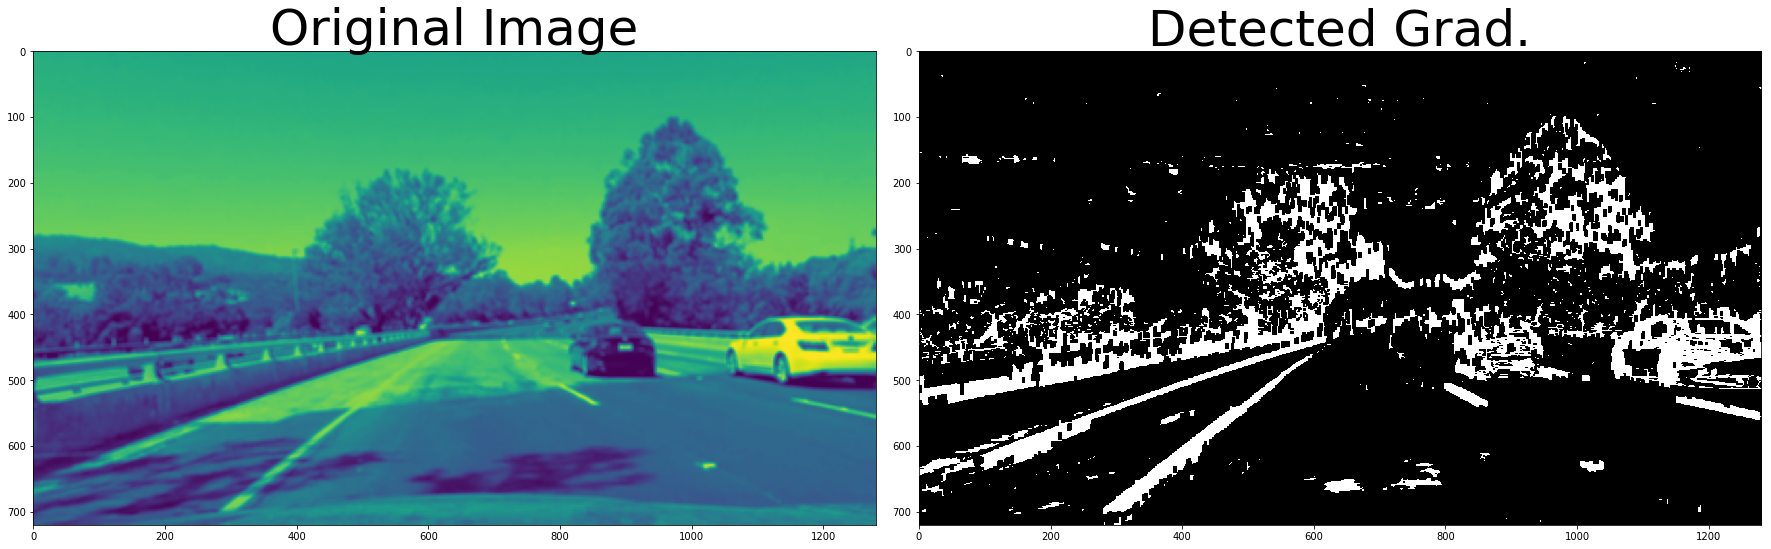

In [121]:
import time
def multiple_threshold(image, min_dt=0, max_dt=255, s_low=128, s_high=255, k_slope1=up_kernel, k_slope2=down_kernel):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    #X not used, noisy
    #Less significant on Y axis , lots of noise
    #Diagonal Sobels!
    pos=abs_sobel_thresh(image, orient='+', thresh_min=min_dt, thresh_max=max_dt)
    neg=abs_sobel_thresh(image, orient='-', thresh_min=min_dt, thresh_max=max_dt)
    bin_diag=np.zeros_like(pos)
    bin_diag[(pos==1)|(neg==1)]=1
    #Close gaps in binary image
    
    bin_diag=cv2.morphologyEx(bin_diag, cv2.MORPH_CLOSE, np.ones((9,3),np.uint8))
    
    # 2)Apply sobel Magnitude
    #Even smaller magnitudes cause noise, not using
    # 3)Apply sobel orientation
    #Lots of noise (even when combining magnitude and orientation)
    # 4) Saturation channel
    s_bin= hls_tresh(low_limit=s_low, high_limit=s_high)
    #Open big spaces, as to desaturate the saturated channel (bad_joke_here)
    
    s_bin=cv2.morphologyEx(s_bin, cv2.MORPH_OPEN, np.ones((1,3),np.uint8))
    
    # 5)Mix all above
    #Only 2 at the end
    binary_output=np.zeros_like(bin_diag)
    binary_output[((bin_diag==1)|(s_bin==1))]=1
    binary_output= cv2.erode(binary_output,np.ones((1,3),np.uint8),iterations = 1)
    return binary_output
 
color_image=mpimg.imread("output_images/undist/test4_undist.jpg")
image=cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
image=cv2.blur(image,(7,7))


start=time.time()
detect=[]
detect= multiple_threshold(image)
print ("Excecution time: {}".format(time.time()-start))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(detect, cmap='gray')
ax2.set_title('Detected Grad.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

In [122]:
img_files = glob.glob('output_images/undist/*.jpg')
save_dir= r'output_images/sobel/'

for file in img_files:
    img= cv2.imread(file,0)
    #img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img=cv2.blur(img,(7,7))
    sufix=file[21:]
    #print (sufix[:-10])
    dst=multiple_threshold(img)
    cv2.imwrite(save_dir+sufix[:-10]+"sobel.jpg", 255*dst)


# Perspective transform

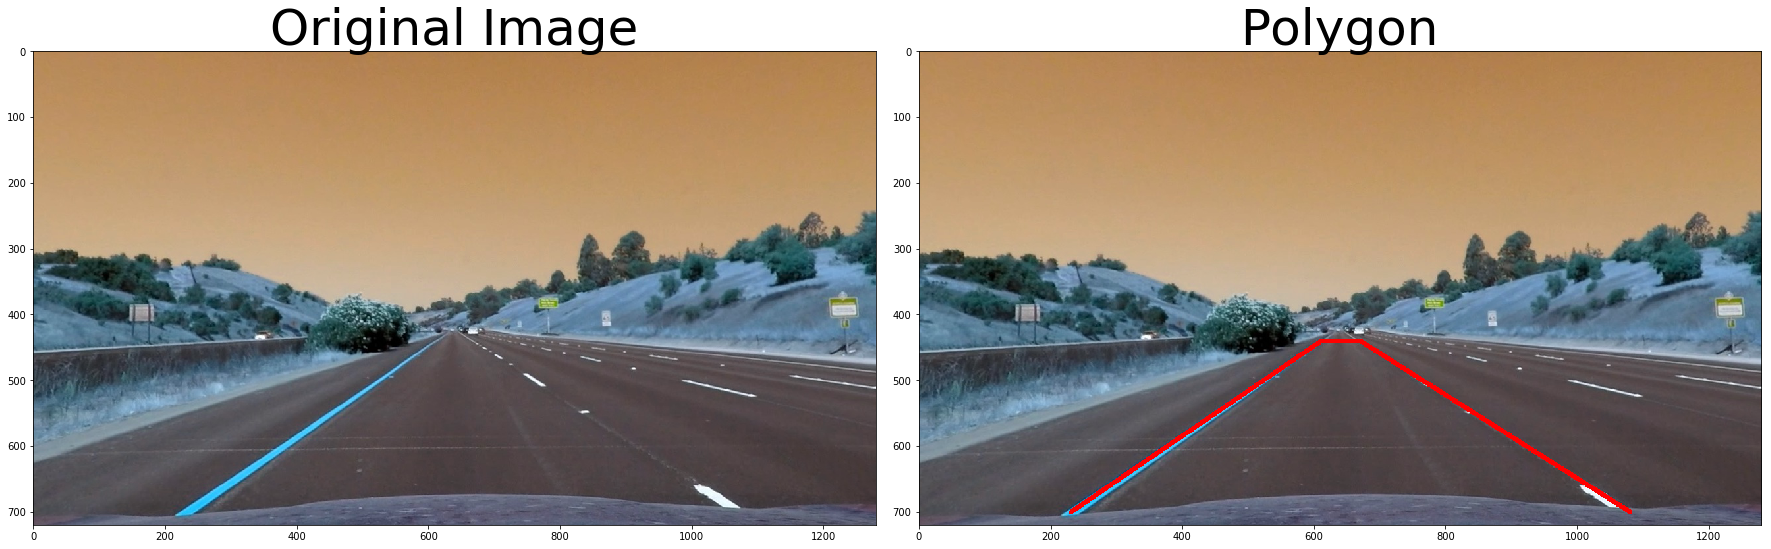

In [7]:
calib_nm="straight_lines1"
color_img=[]
sobel_img= cv2.imread('output_images/sobel/' + calib_nm + '_sobel.jpg',0)
calib_img=cv2.imread('output_images/undist/' + calib_nm + '_undist.jpg')

def draw_poly (img, pts):
    cv2.polylines(img,[pts], False,(255,0,0), 5)
    return img

#Polygon borders
pts = np.array([[230,700],[610,440],[670,440],[1080,700]], np.int32)
pts = pts.reshape((-1,1,2))
poly=np.array(calib_img)
cv2.polylines(poly,[pts], False,(255,0,0), 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calib_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(poly)
ax2.set_title('Polygon', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img_files = glob.glob('output_images/undist/*.jpg')
save_dir= r'output_images/poly/'

for file in img_files:
    img= cv2.imread(file)
    sufix=file[21:]
    dst=draw_poly(img, pts)
    cv2.imwrite(save_dir+sufix, dst)

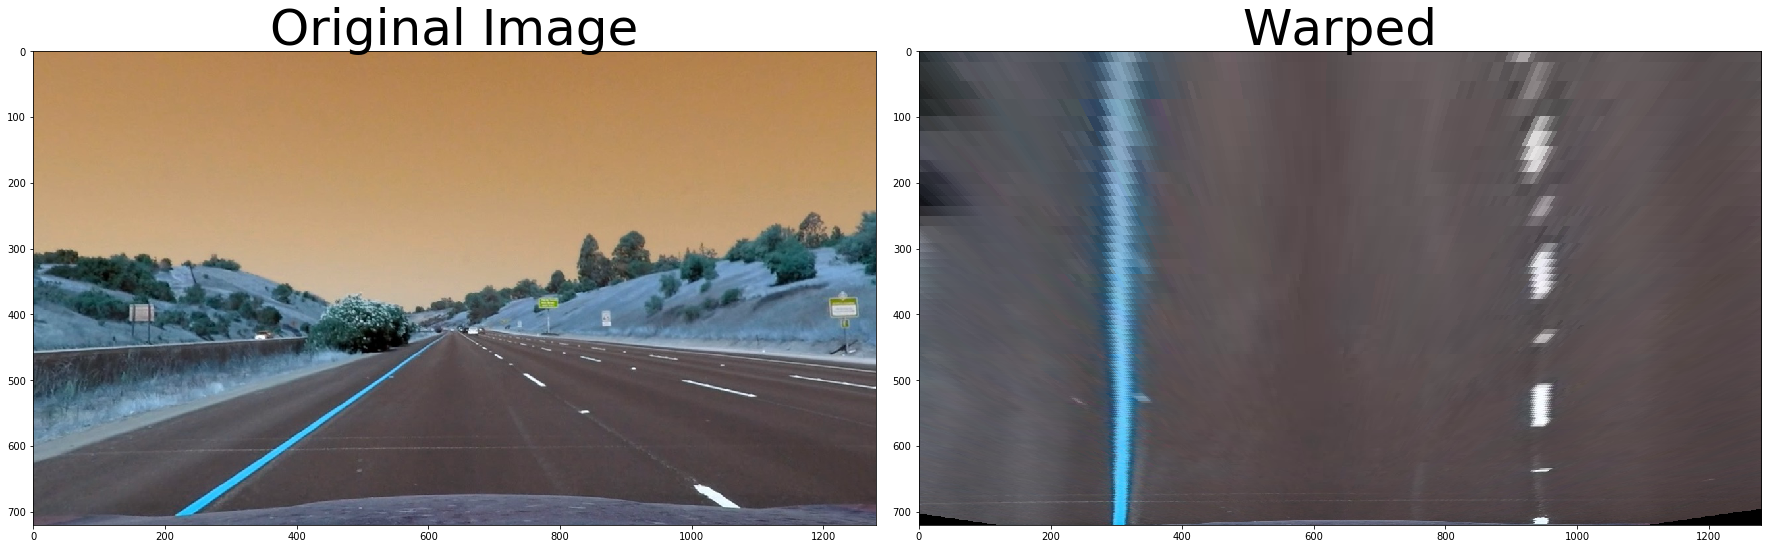

In [8]:
#Destination points for warp
src_pts=np.ndarray.astype(pts.reshape(-1,2), np.float32)
#dst_pts = np.array([[300,750],[300,-100],[1020,-100],[1020,750]], np.float32)
dst_pts = np.array([[300,720],[300,-200],[950,-200],[950,720]], np.float32)
def birds_eye(img, src=src_pts, dst=dst_pts):
    M = cv2.getPerspectiveTransform(src, dst)
    bird = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
    return bird


img_files = glob.glob('output_images/sobel/*.jpg')
save_dir= r'output_images/warp/'
for file in img_files:
    img= cv2.imread(file)
    sufix=file[20:]
    dst=birds_eye(img)
    cv2.imwrite(save_dir+sufix,dst)

img_files = glob.glob('output_images/undist/*.jpg')    
for file in img_files:
    img= cv2.imread(file,0)
    sufix=file[21:]
    dst=birds_eye(img)
    cv2.imwrite(save_dir+sufix,dst)

color_image=cv2.imread(img_files[0])
warp=birds_eye(color_image,src_pts, dst_pts)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warp)
ax2.set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
 

# Detect Lines

(720, 1280)


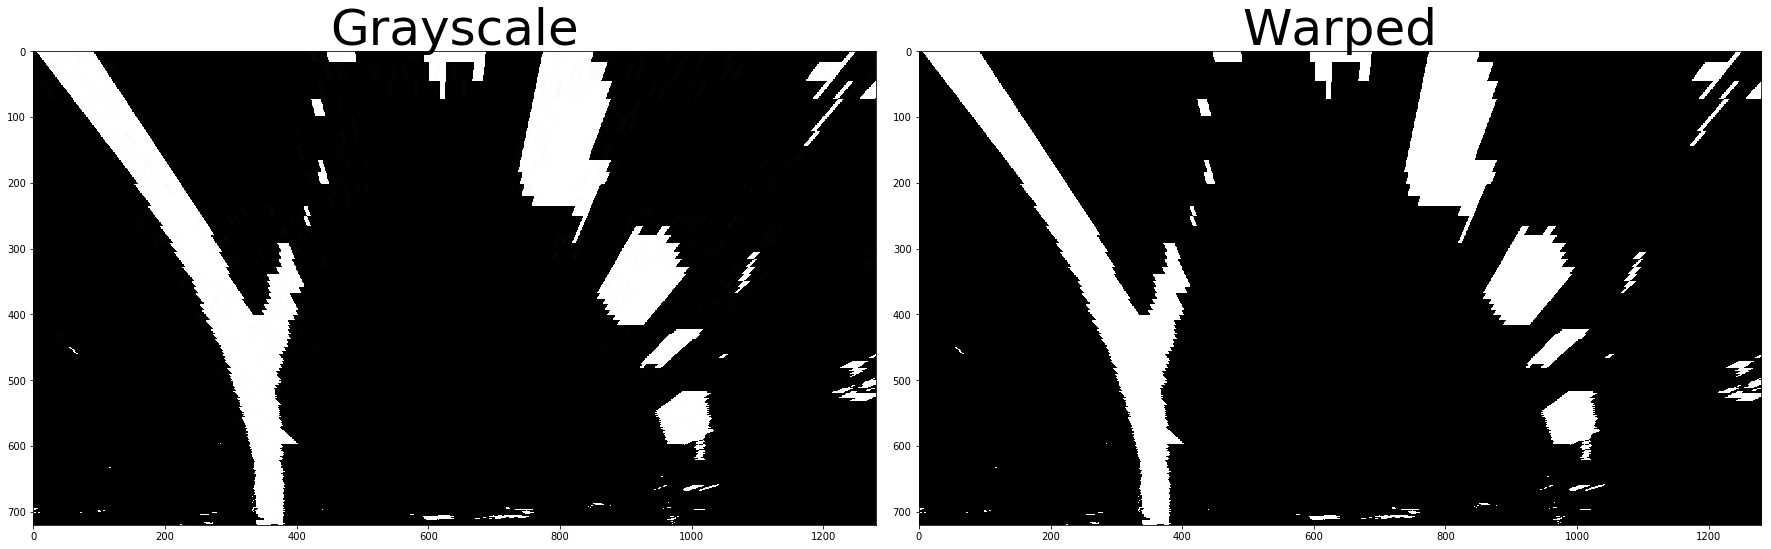

In [9]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import glob
%matplotlib inline

#Get binary image again

img_files = glob.glob('output_images/warp/*_sobel.jpg')

img= cv2.imread(img_files[3],0)
#Get binary image from grayscale readed image
warped=np.zeros_like(img)
warped[img>128]=1
print(warped.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Grayscale', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

603.0
Polynomials
[ -3.98809524e-04   6.46071429e-01   9.59523810e+01]
[ -4.88095238e-04   5.91428571e-01   7.89223810e+02]


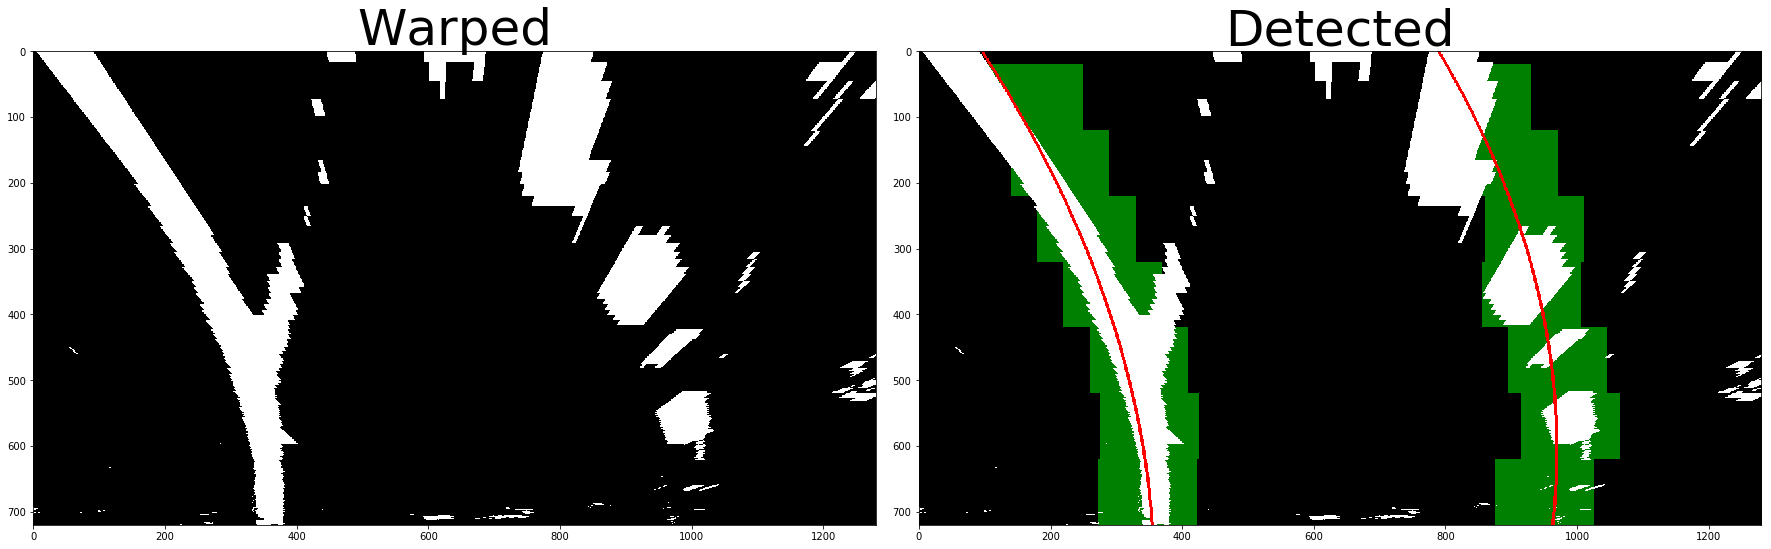

In [117]:
window_width= 150
#window_height=110
window_height=100
margin=40

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin, custom_window=None):
    # Add here condition for custom distribution
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    #Custom window, triangular shape as to push the weight of the convolution to the center
    
    for i in range(int(len(window)/2)):
        window[i]=window[i]+i
        window[-i]=window[-i]+i
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    #Center of both lane markings
    center=r_center-l_center
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    """
            topy=720 - level*window_height
            botomy=720- (level+1)*window_height
            x_left_low=int(window_centroids[level][0]-window_width)
            x_left_high=int(window_centroids[level][0]+window_width)
            

            good_left=((nonzeroy<=topy)&(nonzeroy>botomy)&(nonzerox >= x_left_low) & (nonzerox < x_left_high)).nonzero()[0]
            print("Appending {}". format(len(good_left)))
            print("limits: {}". format([topy, botomy, x_left_low, x_left_high]))
            print(window_centroids[level])
            good_right=((nonzeroy>=level*window_height)&(nonzeroy<(level+1)*window_height)
                      &(nonzerox >= int(window_centroids[level][1]-window_width/2) ) & (nonzerox < int(window_centroids[level][1]-(window_width/2)))).nonzero()[0]
            left_inds.append(good_left)
            right_inds.append(good_right)
        left_inds = np.concatenate(left_inds)
        right_inds = np.concatenate(right_inds)
        print(left_inds.shape)
        leftx=nonzerox[left_inds]
        lefty=nonzeroy[left_inds]
    """ 
    for level in range(1,(int)(warped.shape[0]/window_height)):
        #print(level, l_center, r_center)
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer, mode='full')
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        max_conv = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        if conv_signal[int(max_conv)]>0:
            l_center=max_conv
        else:
            l_center=l_center
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        max_conv = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if conv_signal[int(max_conv)]>0:
            r_center=max_conv
        else:
            r_center=r_center
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids, center

def regression(window_centroids, window_height):
    pt_l=[]
    pt_r=[]
    x_point=[]
    #print("Regression")
    for i, point in enumerate(window_centroids):
        pt_l.append((point[0]))
        pt_r.append((point[1]))
        #print(i*window_height, point[0], point[1])
        x_point.append(720-i*window_height)
    
    fit_l=np.polyfit(x_point, pt_l, 2)
    fit_r=np.polyfit(x_point, pt_r, 2)
    
    return fit_l, fit_r

def draw_regression(warped, window_centroids, window_height):
    if len(window_centroids) > 0:
        left_fit, right_fit = regression(window_centroids, window_height)
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        #get pixels for regression (currently unused)
#        nonzero=warped.nonzero()
#        nonzerox=np.array(nonzero[0])
#        nonzeroy=np.array(nonzero[1])
#        left_inds=[]
#        right_inds=[]
        #window_centroids=list(reversed(window_centroids))
#        print(window_centroids)
        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
           # print("Calling mask on: {}".format(window_centroids[level][0], level))
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255 
            
        # Draw windows
        
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((255*warped,255*warped,255*warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
        #Draw polinomial lines
        ploty =np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_fitx=(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
        right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
        left_line=[]
        right_line=[]
        for y,l,r in zip(ploty, left_fitx, right_fitx):
            
            left_line.append([np.int32(l), np.int32(y)])
            right_line.append([np.int32(r), np.int32(y)])
            
        pts1=np.array(left_line, np.int32)
        pts2=np.array(right_line, np.int32)

        pts1.reshape((-1,1,2))
        pts2.reshape((-1,1,2))
        #output[nonzerox[left_inds], nonzeroy[left_inds]]=[255,0,0]
        output=cv2.polylines(output, [pts1, pts2], False, (255,0,0), 3)

    # If no window centers found, just display orginal road image and empty polynom
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        right_fit=[]
        left_fit=[]
    return output, left_fit, right_fit


    

window_centroids, pic_center = find_window_centroids(warped, window_width, window_height, margin)
print(pic_center)

detect_lines=[]
detect_lines, left_fit, right_fit =draw_regression(warped, window_centroids, window_height)
#print(detect.shape)
print("Polynomials")
print(left_fit)
print(right_fit)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped', fontsize=50)
ax2.imshow(detect_lines)
ax2.set_title('Detected', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [302]:
save_dir= r'output_images/detect/'
for file in img_files:
    img= cv2.imread(file,0)
    #Get binary image from grayscale readed image
    warped=np.zeros_like(img)
    warped[img>128]=1
    sufix=file[19:]
    #print(sufix[:-10])
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    detect, left_fit, right_fit =draw_regression(warped, window_centroids, window_height)
    #print(left_fit)
    #print(right_fit)
    cv2.imwrite(save_dir+sufix[:-10]+'_regre.jpg', detect)

# Curvature

In [314]:
def tangent_circle(poly_l, poly_r, pic_center, eval_point=720):
    ym_per_pix = 3.0/106
    xm_per_pix = 3.7/650
    ploty = np.linspace(0, 719, num=720)
    leftx=np.array([poly_l[0]*(y**2)+poly_l[1]*(y)+poly_l[0] for y in ploty])
    rightx=np.array([poly_r[0]*(y**2)+poly_r[1]*(y)+poly_r[0] for y in ploty])
    
    center=(pic_center-700)*xm_per_pix

    #center*=xm_per_pix
    poly_ml=np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    poly_mr=np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    
    eval_point*=ym_per_pix
    
    curv_l = ((1 + (2*poly_ml[0]*eval_point + poly_ml[1])**2)**1.5) / np.absolute(2*poly_ml[0])
    curv_r = ((1 + (2*poly_mr[0]*eval_point + poly_mr[1])**2)**1.5) / np.absolute(2*poly_mr[0])
    
    
    return curv_l, curv_r, center
    
print(tangent_circle(left_fit, right_fit, pic_center))
#print(tangent_circle(right_fit))


(309.66364688692767, 162.24807079065008, -0.53507692307692312)
